### **SETUP & IMPORTS**

In [ ]:
!pip install import-ipynb
!pip install biopython==1.84

In [ ]:
import pandas as pd
import numpy as np
import import_ipynb

# Load ML_features.tsv generated by the Feature Extraction module
from Features_extraction_SVM import *

Output streaming troncato alle ultime 5000 righe.


Feature matrix shape: (8021, 48)
Feature extraction completed successfully.
File saved as: ML_features.tsv
Total samples: 8021, Total features: 32


### **PREPROCESSING**
Apply `MinMaxScaler` to normalize variables between 0 and 1.

In [ ]:
# Scale features between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### FEATURE SELECTION (RANDOM FOREST)
Select the most important features based on their importance scores, keeping those above the **median Gini importance**.

From 48 features the method selected 24.

In [ ]:
# Feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Train Random Forest on scaled data
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_scaled, y)

# Select the features based on Random Forest importance scores
selector = SelectFromModel(rf, prefit=True, threshold='median')
X_selected = selector.transform(X_scaled)

print("Features before:", X.shape[1])
print("Features after:", X_selected.shape[1])


Features before: 48
Features after: 24


### **SVM HYPERPARAMETER TUNING WITH GRID SEARCH**

- Explore different combinations of hyperparameters (`C`, `kernel`, `gamma`).
  - `C`: `[0.1, 1, 10]` — Regularization parameter controlling the trade-off between margin width and classification error.  
  - `kernel`: `['linear', 'poly', 'rbf', 'sigmoid']` — Specifies the kernel type to transform data (linear, polynomial, radial basis function, sigmoid).  
  - `gamma`: `['scale', 'auto']` — Kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’ kernels, affecting the influence of single training examples.

- Use 5-fold stratified cross-validation to evaluate each combination.  
- Select the parameters that achieve the highest accuracy, optimizing model performance.


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM and 5-fold cross-validation
svc = svm.SVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Find the best parameters
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model on scaled data
grid.fit(X_scaled, y)

# Display best parameters and accuracy
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.964468967767497


### **VISUALIZING BIOPHYSICAL FEATURE IMPORTANCE**

- Focus on biophysical features (e.g., hydrophobicity, charge, size, alpha-helix propensity, transmembrane regions) from the selected features
  
- Retrieve their Gini importance scores from the trained Random Forest.

- Sort and display the top features to understand which biophysical properties contribute most to the model.  

- Visualize the top 10 features with a horizontal bar plot for clear interpretation.



Features ordered by Gini importance (Biophysical Features Only):
       feature  importance
0   alpha_mean    0.060124
1  charge_mean    0.051229
2    trans_max    0.038609
3    hydro_max    0.034360
4    alpha_max    0.033762
5   hydro_mean    0.033190
6   trans_mean    0.031787
7    size_mean    0.029796
8     size_max    0.024055
9   charge_max    0.022627


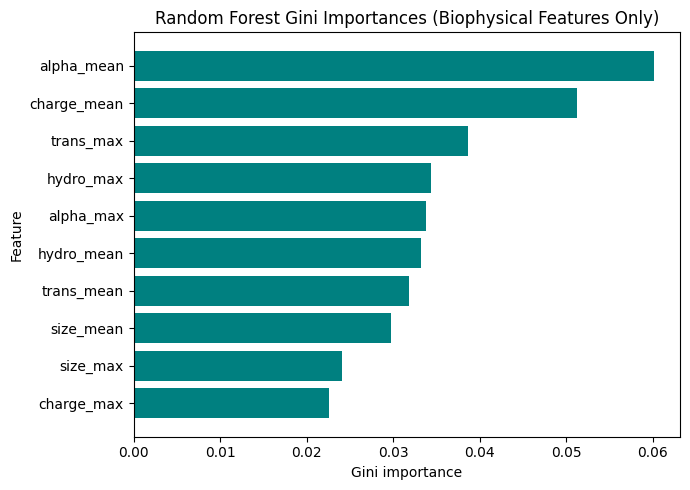

In [ ]:
import matplotlib.pyplot as plt

# Define features
biophysical_features = ['hydro_max','hydro_mean','charge_max','charge_mean','alpha_max','alpha_mean','trans_max','trans_mean','size_max','size_mean']
amino_acid_features = [f'comp_{a}' for a in alphabet]
all_feature_names = list(X.columns)

# Get indices of the selected features from the original feature set
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

# Get the Gini importances for the selected features
selected_gini_importance = rf.feature_importances_[selected_feature_indices]


# Filter for selected biophysical features and their importances
biophysical_selected_feature_names = [feat for feat in selected_feature_names if feat in biophysical_features]
biophysical_gini_importance = [selected_gini_importance[selected_feature_names.index(feat)] for feat in biophysical_selected_feature_names]


# Create a sorted DataFrame of biophysical features by Gini importance
gini_imp = pd.Series(biophysical_gini_importance, index=biophysical_selected_feature_names).sort_values(ascending=False)
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]

print("\nFeatures ordered by Gini importance (Biophysical Features Only):")
print(gini_df.head(10))

plt.figure(figsize=(7,5))
top10 = gini_df.head(10).iloc[::-1]
plt.barh(top10["feature"], top10["importance"], color='teal')
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("Random Forest Gini Importances (Biophysical Features Only)")
plt.tight_layout()
plt.show()

### **TRAIN-VALIDATION SPLIT**

- Split the selected features and target labels into training and validation sets.  

- Use 80% of the data for training and 20% for validation.  

- Apply stratification to preserve the class distribution in both sets.  

- This allows us to train the model and evaluate its performance on unseen data.


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (6416, 24)
X_val shape: (1605, 24)
y_train shape: (6416,)
y_val shape: (1605,)


### **SVM PIPELINE**

- Create a pipeline that first scales the features using `MinMaxScaler`.  

- Then train an SVM with specified `C` and `gamma` parameters.  

- This ensures consistent preprocessing and model training in a single step, avoiding data leakage.


In [ ]:
from sklearn.pipeline import Pipeline

# Build a pipepline that scales the data and trains SVM with given parameters
def svm_pipeline(C, gamma):
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('svm', svm.SVC(C=C, gamma=gamma))
    ])
    return pipe

### **EVALUATING SVM ACCURACY ON TOP FEATURES**

- Assess how SVM performance changes when using only the top `k` features ranked by Random Forest Gini importance.  

- Iterate over a range of `k` values to find the optimal number of features that maximizes validation accuracy.  

- Use the best SVM parameters found from GridSearchCV for consistency.  

- Plot validation accuracy against `k` to visualize the effect of feature selection.


Best k on validation (using baseline best params): k=10, val_acc=0.913


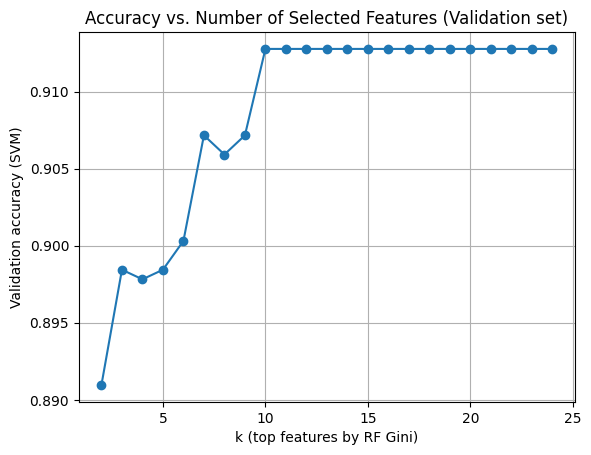

In [ ]:
def accuracy_on_subset(C, gamma, subset_features):

    # # Evaluate SVM accuracy using only a subset of features
    feature_names = [f'hydro_max','hydro_mean','charge_max','charge_mean','alpha_max','alpha_mean','trans_max','trans_mean','size_max','size_mean'] + [f'comp_{a}' for a in alphabet]
    idx = [feature_names.index(f) for f in subset_features]

    Xtr = X_train[:, idx]
    Xva = X_val[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)
    return pipe.score(Xva, y_val)

# Test accuracy by varying the number of top features
ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
curve = []

# Get the best parameters found by GridSearchCV
best_params_base = grid.best_params_
for k in ks:
    subset = gini_df["feature"].head(k).tolist()
    acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
    curve.append(acc_k)

# Find the best k (number of selected features) and plot validation accuracy
best_k_idx = int(np.argmax(curve))
best_k = ks[best_k_idx]
print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

plt.figure()
plt.plot(ks, curve, marker="o")
plt.xlabel("k (top features by RF Gini)")
plt.ylabel("Validation accuracy (SVM)")
plt.title("Accuracy vs. Number of Selected Features (Validation set)")
plt.grid(True)
plt.show()

### **FINAL SVM TRAINING ON SELECTED FEATURES**

- Select the top `k` most important features based on Random Forest Gini importance.  

- Split the dataset into training, validation, and test sets to fairly evaluate the model.  

- Perform a grid search on the selected features to fine-tune `C` and `gamma` for SVM.

- Train the final SVM on the training set and evaluate on the test set.  

- Compare results with a baseline model trained on all features using previously tuned parameters.


In [ ]:
# Get indices of the top-k most important features
best_subset = gini_df["feature"].head(best_k).tolist()
all_feature_names = ['hydro_max','hydro_mean','charge_max','charge_mean','alpha_max','alpha_mean','trans_max','trans_mean','size_max','size_mean'] + [f'comp_{a}' for a in alphabet]
idx = [all_feature_names.index(f) for f in best_subset]

# Split dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Keep only selected features for each subset
Xtr_sel = X_train[:, idx]
Xva_sel = X_val[:, idx]
Xte_sel = X_test[:, idx]

# Grid search on selected features
C_grid = [0.1, 1, 10]
gamma_grid = ['scale', 'auto']
best_score_sel = -np.inf
best_params_sel = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(Xtr_sel, y_train)
        val_acc = pipe.score(Xva_sel, y_val)
        if val_acc > best_score_sel:
            best_score_sel = val_acc
            best_params_sel = {"C": C, "gamma": gamma}

# Train final model and test on unseen data
final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
final_pipe.fit(Xtr_sel, y_train)
test_acc = final_pipe.score(Xte_sel, y_test)

# Print main results
print("Selected features (best k):", best_subset)
print("Best validation accuracy on selected features:", f"{best_score_sel:.3f}", "with", best_params_sel)
print("Test accuracy (selected features, tuned on val):", f"{test_acc:.3f}")

# # Baseline model using all features for comparison
baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
baseline_pipe.fit(X_train, y_train)
test_acc_all = baseline_pipe.score(X_test, y_test)
print("Test accuracy (all features, baseline tuned on val):", f"{test_acc_all:.3f}")

Selected features (best k): ['alpha_mean', 'charge_mean', 'trans_max', 'hydro_max', 'alpha_max', 'hydro_mean', 'trans_mean', 'size_mean', 'size_max', 'charge_max']
Best validation accuracy on selected features: 0.906 with {'C': 1, 'gamma': 'scale'}
Test accuracy (selected features, tuned on val): 0.910
Test accuracy (all features, baseline tuned on val): 0.967


### **FINAL EVALUATION OF BEST SVM MODEL**

- Evaluate the best SVM model on the full dataset.  
- Compute key performance metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - MCC  
- Plot the **Confusion Matrix**  and the **Precision-Recall curve**  
- Generate a detailed **classification report** for positive and negative classes.  
- Save the final metrics to a **TSV file** for record-keeping and further analysis.



 Final Evaluation on Full Dataset
---------------------------------------------
Accuracy:   0.974
Precision:  0.897
Recall:     0.856
F1-score:   0.876
MCC:        0.861
---------------------------------------------


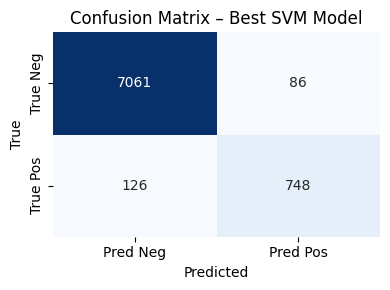


Detailed Classification Report:

              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99      7147
    Positive       0.90      0.86      0.88       874

    accuracy                           0.97      8021
   macro avg       0.94      0.92      0.93      8021
weighted avg       0.97      0.97      0.97      8021



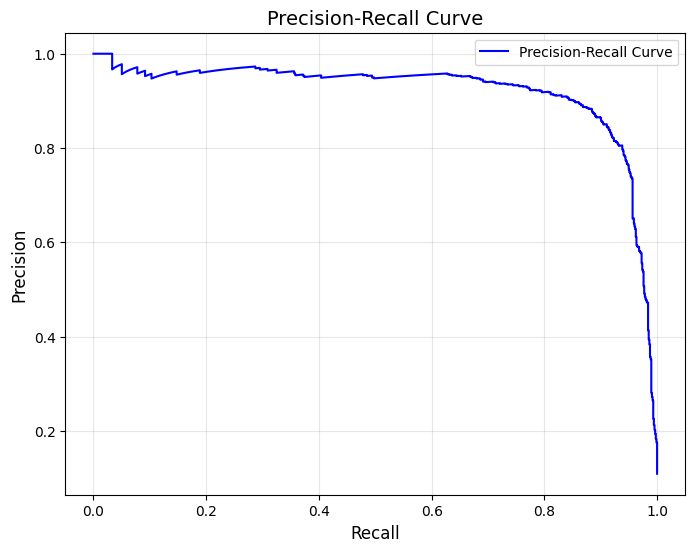


 Metrics saved to 'final_svm_metrics.tsv'


In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report, matthews_corrcoef,
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,
)
import seaborn as sns
import os

# Evaluate best SVM model on the full dataset
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_scaled)
try:
    y_prob = best_svm.decision_function(X_scaled)
except:
    y_prob = None


# Compute main performance metrics
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
mcc = matthews_corrcoef(y, y_pred)

print("\n Final Evaluation on Full Dataset")
print("-" * 45)
print(f"Accuracy:   {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}")
print(f"MCC:        {mcc:.3f}")
print("-" * 45)


cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Neg','Pred Pos'], yticklabels=['True Neg','True Pos'])
plt.title("Confusion Matrix – Best SVM Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


print("\nDetailed Classification Report:\n")
print(classification_report(y, y_pred, target_names=["Negative", "Positive"]))

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, y_prob)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color='blue')
plt.title("Precision-Recall Curve", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

metrics_dict = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "MCC": mcc
}


results_df = pd.DataFrame([metrics_dict])
results_file_path = 'final_svm_metrics.tsv'
results_df.to_csv(results_file_path, sep="\t", index=False)

print(f"\n Metrics saved to '{results_file_path}'")